# Denoising Autoencoders for Time series data

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from os import listdir
import pandas as pd
import datetime
from pytz import timezone
from scipy import signal
import matplotlib.pyplot as plt

Let's set the window size for the time serie processing.

In [3]:
window_size = 1800

Let's define a few utility functions to split time series into rolling windows:

In [4]:
# https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
def windowize(seq, w_size=window_size):
    dd = list()
    for w in window(seq, w_size):
        dd += [np.array(w)]
    dd = np.array(dd)
    return dd

In [5]:
from pandas import concat

def prepare_train_features(input_series,
                           window_size=5,
                           step_size=1,
                           num_predicted_samples=1):
    col_names = []
    col_vals = []
    df_data = None
    df_forecast = None
    
    for i in range(window_size+num_predicted_samples):
        if df_data is None:
            df_data = input_series.to_frame()
        if i>0:
            df_data = df_data.shift(-step_size)
        col_vals.append( df_data )
        col_names.append( ("f_"+str(i)) if i < window_size else ("y_"+str(i-window_size))  )

    df_data = concat(col_vals, axis=1)
    df_data.columns = col_names
    
    return df_data

## Denoising gaussian noise

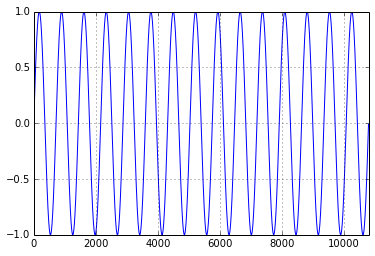

In [6]:
amplitude = 1.0
sequence_length = window_size * 6
f = 15 # 5Hz
sampling_rate = 1

x = np.arange(sequence_length)
y = amplitude * np.sin(((2 * np.pi) * f * x) / (sampling_rate*sequence_length))

ts = pd.Series(y, index=x)
ts.plot()

Max noise 3.287787897172018


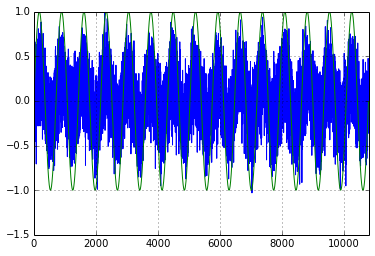

In [7]:
seed = 1234
np.random.seed(seed)
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html
noise = np.random.normal(0, 1, len(x))
print "Max noise", np.amax(noise)

y_noise = y + noise
y_noise = y_noise / np.amax(y_noise)

noisy_ts = pd.Series(y_noise, index=x)

noisy_ts.plot()
plt.subplot()
ts.plot()

In [8]:
num_windows = len(x) / window_size
print "found", num_windows, "windows of", window_size, "samples"

ceil = False
split_rate = 0.8

import math
train_windows = int(math.ceil(num_windows * split_rate) if ceil else math.floor(num_windows * split_rate))

print "train windows", train_windows
print "test windows", num_windows - train_windows

# split in train and test data
ts_train = ts.iloc[0:train_windows*window_size]
ts_test = ts.iloc[train_windows*window_size:]

noisy_ts_train = noisy_ts.iloc[0:train_windows*window_size]
noisy_ts_test = noisy_ts.iloc[train_windows*window_size:]

found 6 windows of 1800 samples
train windows 4
test windows 2


In [9]:
x_ts_train = windowize(noisy_ts_train)
print x_ts_train.shape

x_ts_test = windowize(noisy_ts_test)
print x_ts_test.shape

y_ts_train = windowize(ts_train)
print y_ts_train.shape

y_ts_test = windowize(ts_test)
print y_ts_test.shape

(5401, 1800)
(1801, 1800)
(5401, 1800)
(1801, 1800)


In [10]:
x_ts_train = np.expand_dims(x_ts_train, axis=2)
print x_ts_train.shape

x_ts_test = np.expand_dims(x_ts_test, axis=2)
print x_ts_test.shape

y_ts_train = np.expand_dims(y_ts_train, axis=2)
print y_ts_train.shape

y_ts_test = np.expand_dims(y_ts_test, axis=2)
print y_ts_test.shape

(5401, 1800, 1)
(1801, 1800, 1)
(5401, 1800, 1)
(1801, 1800, 1)


### Denoising autoencoder with dense layers

In [11]:
from keras import Input, metrics
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, K
from keras.optimizers import Adadelta, SGD

Using TensorFlow backend.


In [12]:
dense_autoencoder = Sequential(name="Dense_DenoisingAutoencoder")

# todo

### Denoising autoencoder using convolution layers

In [14]:
convolution_autoencoder = Sequential(name="CNN_DenoisingAutoencoder")

# encoder
# https://keras.io/layers/convolutional/#conv1d
# stage 1: 
# window_size x 64
convolution_autoencoder.add(Conv1D(input_shape=(window_size,1),
                       filters=64, # dimension of the output space
                       kernel_size=3, # length of the convolution window
                       padding="same",
                       activation="relu"
                      ) 
               )
# (window_size/2) x 64
convolution_autoencoder.add(MaxPooling1D(pool_size=2, padding="same"))
# stage 2: 
# (window_size/2) x 128
convolution_autoencoder.add(Conv1D(filters=128,
                                   kernel_size=3,
                                   padding='same',
                                   activation='relu'))
# (window_size/4) x 128
convolution_autoencoder.add(MaxPooling1D(pool_size=2, padding='same'))

# decoder
# stage 3:
# (window_size/4) x 128
convolution_autoencoder.add(Conv1D(filters=128,
                                   kernel_size=3,
                                   padding='same',
                                   activation='relu'))
# (window_size/2) x 128                
convolution_autoencoder.add(UpSampling1D(size=2))

# stage 4: 
# (window_size/2) x 64
convolution_autoencoder.add(Conv1D(filters=64,
                                   kernel_size=3,
                                   padding='same',
                                   activation='relu'))
# window_size x 64
convolution_autoencoder.add(UpSampling1D(size=2))                

# window_size x 1
convolution_autoencoder.add(Conv1D(filters=1,
                                   kernel_size=3,
                                   padding='same',
                                   #activation='sigmoid'
                                   activation='tanh'
                                  )
                           )

convolution_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print(convolution_autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1800, 64)          256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 900, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 900, 128)          24704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 450, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 450, 128)          49280     
_________________________________________________________________
up_sampling1d_3 (UpSampling1 (None, 900, 128)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 900, 64)           24640     
__________

In [15]:
seed = 1234
np.random.seed(seed)

In [16]:
epochs=2
batch_size=15

convolution_autoencoder.fit(x=x_ts_train,
                            y=y_ts_train,
                            validation_data=(x_ts_test, y_ts_test),
                            shuffle=True,
                            epochs=epochs,
                            batch_size=batch_size)

Train on 5401 samples, validate on 1801 samples
Epoch 1/2
5401/5401 [==============================] - 64s 12ms/step - loss: 0.0385 - val_loss: 0.0340
Epoch 2/2
5401/5401 [==============================] - 57s 11ms/step - loss: 0.0174 - val_loss: 0.0395


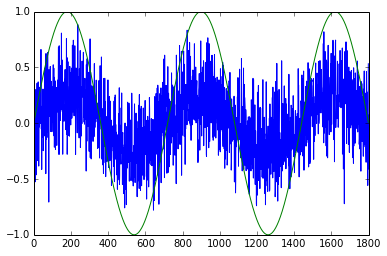

In [17]:
plt.plot(range(len(x_ts_train[0])), x_ts_train[0])
plt.subplot()
plt.plot(range(len(y_ts_train[0])), y_ts_train[0])

[[[ 0.02723671]
  [ 0.08140629]
  [ 0.08691379]
  ...
  [-0.34166008]
  [-0.31381702]
  [-0.06709861]]]
[[[ 0.02723671]
  [ 0.08140629]
  [ 0.08691379]
  ...
  [-0.34166008]
  [-0.31381702]
  [-0.06709861]]]
[ 0.02723671  0.08140629  0.08691379 ... -0.34166008 -0.31381702
 -0.06709861]


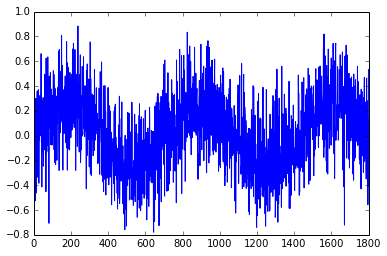

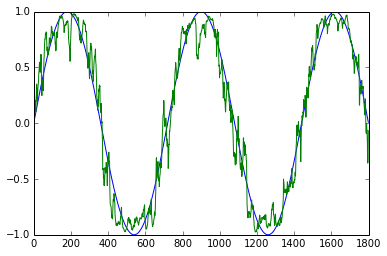

In [18]:
# example prediction on the noisy input signal
decoded = convolution_autoencoder.predict(
    np.reshape(x_ts_train[0], (1, window_size, 1))
)

print decoded * amplitude
decoded.shape
dec_y = np.reshape(decoded, window_size)
print decoded
print dec_y

plt.plot(x_ts_train[0])
plt.figure()
plt.plot(y_ts_train[0])
plt.plot(dec_y)

## Load disaggreation as denoising problem

In this notebook we explore active power time series from the open GREEND dataset, which is freely available for download at https://sourceforge.net/projects/greend/. Moreover, we preprocess the dataset using the sample code from https://github.com/pilillo/needle-load-detector. Similar studies were carried out in https://www.researchgate.net/profile/Roberto_Bonfigli/publication/321287989_Denoising_Autoencoders_for_Non-Intrusive_Load_Monitoring_Improvements_and_Comparative_Evaluation/links/5a2e63d445851552ae7f1fff/Denoising-Autoencoders-for-Non-Intrusive-Load-Monitoring-Improvements-and-Comparative-Evaluation.pdf and compared to state-based approaches, i.e. variants of hidden-markov models.

In [19]:
from load_disaggregator import *

# building 1    
devices = ['000D6F00036BB04C', '000D6F00029C2BD7', '000D6F000353AC8C', 
           '000D6F0003562E10', '000D6F0003562C48', '000D6F00029C2984', 
           '000D6F000353AE51', '000D6F0003562C0F', '000D6F0003562BF6']

dataset_folder = "data/GREEND_0-2_300615/"

processor = DatasetProcessor(dataset_folder)        
df = processor.get_dataframe(building=1, days_no=4)

Plot the initial raw data from the GREEND.

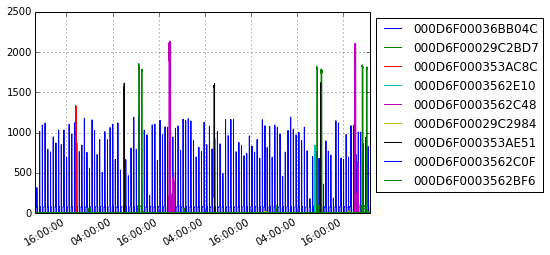

In [20]:
ax = df.plot(legend=False)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

#### Preprocessing the power time series

Remove NaN values using both pad and bfill together.

In [21]:
# preprocess the dataset
preprocessed = processor.remove_holes() # fill with pad and bfill
preprocessed.head()

,000D6F00036BB04C,000D6F00029C2BD7,000D6F000353AC8C,000D6F0003562E10,000D6F0003562C48,000D6F00029C2984,000D6F000353AE51,000D6F0003562C0F,000D6F0003562BF6
2014-03-12 07:52:42.470790,2.274737,0,2.171969,0,0,16.978532,0,0,0
2014-03-12 07:52:43.166152,0.000000,0,0.000000,0,0,19.085350,0,0,0
2014-03-12 07:52:44.153153,2.274737,0,2.171969,0,0,16.978532,0,0,0
2014-03-12 07:52:45.183690,0.000000,0,0.000000,0,0,16.978532,0,0,0
2014-03-12 07:52:46.503409,0.000000,0,0.000000,0,0,16.978532,0,0,0


Make sure the period of the data is uniform to 1 Hz (i.e. 1 second).

In [22]:
# makes sure the signal is at 1Hz
preprocessed = processor.uniform_period()
preprocessed.head()

,000D6F00036BB04C,000D6F00029C2BD7,000D6F000353AC8C,000D6F0003562E10,000D6F0003562C48,000D6F00029C2984,000D6F000353AE51,000D6F0003562C0F,000D6F0003562BF6
2014-03-12 07:52:42,2.274737,0,2.171969,0,0,16.978532,0,0,0
2014-03-12 07:52:43,0.000000,0,0.000000,0,0,19.085350,0,0,0
2014-03-12 07:52:44,2.274737,0,2.171969,0,0,16.978532,0,0,0
2014-03-12 07:52:45,0.000000,0,0.000000,0,0,16.978532,0,0,0
2014-03-12 07:52:46,0.000000,0,0.000000,0,0,16.978532,0,0,0


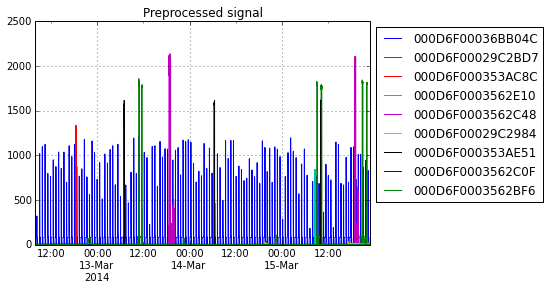

In [23]:
ax = preprocessed.plot(title="Preprocessed signal", legend=False)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

Plot the aggregated signal and the individual devices.

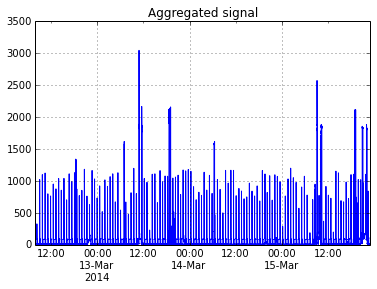

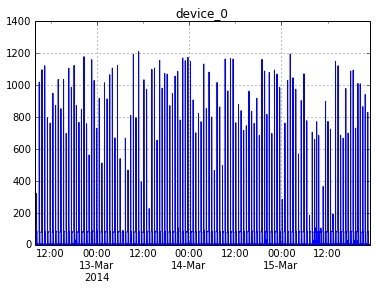

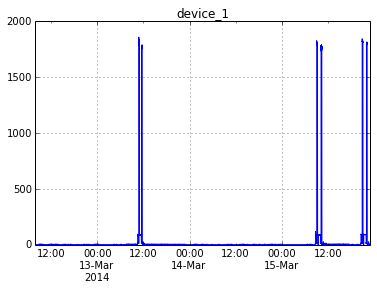

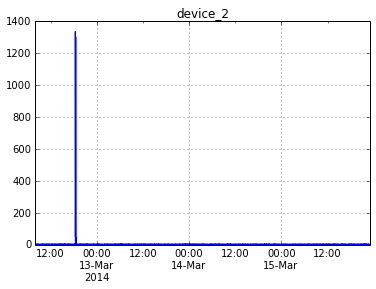

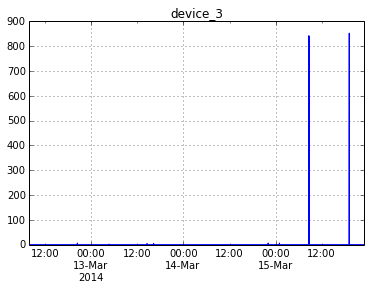

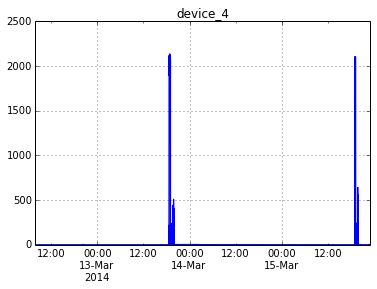

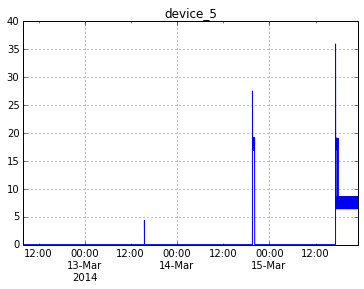

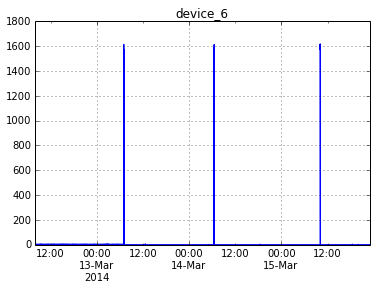

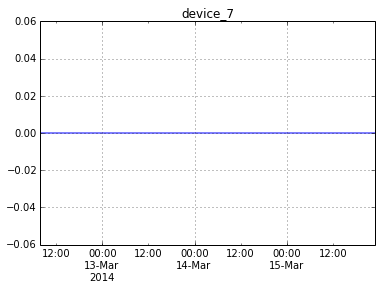

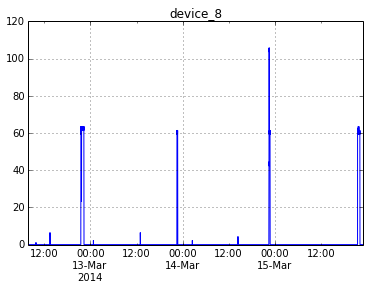

In [24]:
processor.get_aggregated_signal().plot(title="Aggregated signal")

for i, t in enumerate(devices):
    if t is not None and len(t)>0:
        plt.figure()
        processor.get_disaggregated_signal(devices[i]).plot(title="device_"+str(i))

#### Extracting device signatures

Extract a signature for each device.

In [25]:
template_folder="" # save to local folder

In [ ]:
# Extract signatures for individual devices
processor.get_datastore(template_folder+"dev_signatures.h5")

# Device 0 (fridge)
signature0 = processor.select_datetime_interval('2014-03-12 08:18:40', '2014-03-12 08:29:00')[devices[0]]
processor.add_signature('devices/d0', signature0)

#Device 1 (dishwasher)
signature1 = processor.select_datetime_interval('2014-03-13 10:28:30',  '2014-03-13 11:45:00')[devices[1]]
processor.add_signature('devices/d1', signature1)

# Device 2 (microwave)
signature2 = processor.select_datetime_interval('2014-03-12 18:24:40',  '2014-03-12 18:26:20')[devices[2]]
processor.add_signature('devices/d2', signature2)

# Device 3 water kettle
signature3 = processor.select_datetime_interval('2014-03-15 08:32:00', '2014-03-15 08:42:20')[devices[3]]
processor.add_signature('devices/d3', signature3)

# Device 4
signature4 = processor.select_datetime_interval('2014-03-13 18:32:00', '2014-03-13 19:58:30')[devices[4]]    # on the second day (that is why we use datetime)
processor.add_signature('devices/d4', signature4)

# Device 5 (amplifier)
#signature = processor.select_time_interval('18:24:40', '18:26:20')[devices[5]]
#signature5 = processor.select_datetime_interval('2014-03-12 18:24:40', '2014-03-12 18:26:20')[devices[5]]

# Device 6 (hair dryer + charger )
signature6 = processor.select_datetime_interval('2014-03-15 10:03:45', '2014-03-15 10:06:30')[devices[6]]
processor.add_signature('devices/d6', signature6)

# Device 7 (food processor) --> neverused
    
# Device 8 Bedside lamp
signature8 = processor.select_datetime_interval('2014-03-13 22:27:45', '2014-03-13 22:37:40')[devices[8]]
processor.add_signature('devices/d8', signature8)

processor.close_datastore()

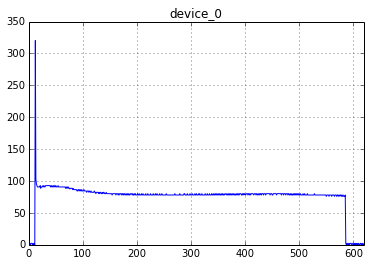

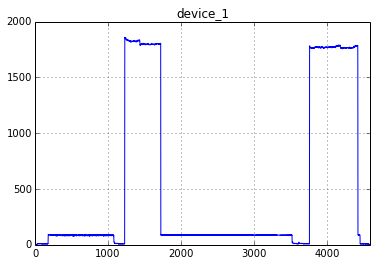

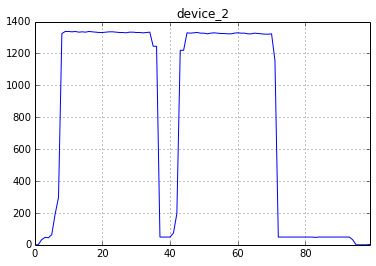

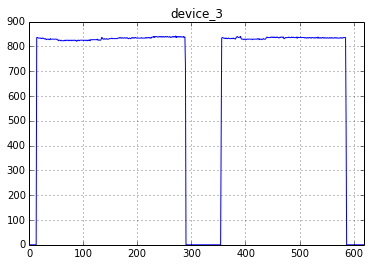

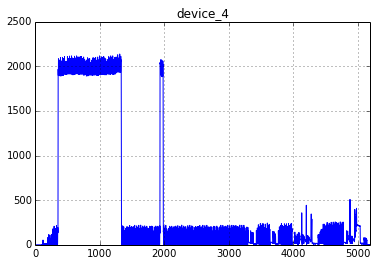

In [27]:
processor.get_datastore(template_folder+"dev_signatures.h5")

templates = [processor.get_signature('devices/d0'),
             processor.get_signature('devices/d1'),
             processor.get_signature('devices/d2'),
             processor.get_signature('devices/d3'),
             processor.get_signature('devices/d4'),
             None, 
             None, #processor.get_signature('devices/d6'),
             None,
             None] # processor.get_signature('devices/d8') ]

for i, t in enumerate(templates):
    if t is not None and (not t.empty):
        plt.figure()
        t.plot(title="device_"+str(i))

#### Normalizing the dataset

In [28]:
dev_id = 1

x = processor.get_aggregated_signal()
y = processor.get_disaggregated_signal(devices[i])

print x.shape
print y.shape

(313392,)
(313392,)


In [29]:
# find the peak power for each device from the extracted templates
max_t = []
for i, t in enumerate(templates):
    if t is not None and (not t.empty):
        max_t.append( np.amax(t) )
    else:
        max_t.append( 0 )
print max_t
# this is the peak power we shall expect as input
max_x = sum(max_t)
print max_x
# Problem 1: for different houses we would have completely different models
# to generalize a house we should use typical device categories
# for the ouput we can use the max_t of the specific device we want to model

[320.2258102791834, 1858.7950463050927, 1337.9992326344902, 841.9707410934543, 2136.9037383414134, 0, 0, 0, 0]
6495.8945686536335


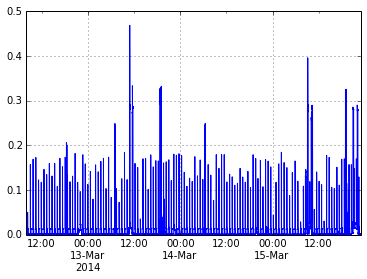

In [30]:
normalized_x = x / max_x
normalized_x.plot()

Normalizing y based on device  1 whose peak power is  1858.7950463050927


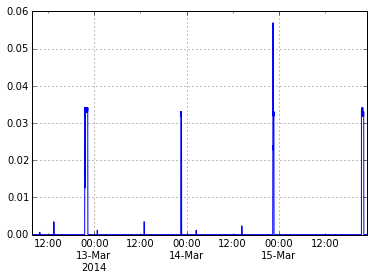

In [31]:
print "Normalizing y based on device ", dev_id, "whose peak power is ", max_t[dev_id]
normalized_y = y / max_t[dev_id]
normalized_y.plot()

#### Splitting in train and test datasets

In [32]:
# split in train and test data based on a specific date time
split_datetime = "2014-03-15 00:00:00"

x_train = normalized_x[normalized_x.index < split_datetime]
y_train = normalized_y[normalized_y.index < split_datetime]

print x_train.shape
print y_train.shape

x_test = normalized_x[normalized_x.index >= split_datetime]
y_test = normalized_y[normalized_y.index >= split_datetime]

print x_test.shape
print y_test.shape

(230838,)
(230838,)
(82554,)
(82554,)


#### Create windows of nilm_window_size that can be used to train the autoencoder

In [34]:
# set the size of the detector to the device template
nilm_window_size = len(templates[dev_id])
print nilm_window_size
# since 4590 is difficult to divide by 2 and leads to asymmetries 4590/2/2=1147.5 (which is rounded to 1148)
# let's increase it to 4600. 4600/2/2 = 1150.
nilm_window_size=4600
print nilm_window_size

4590
4600


In [35]:
# def windowize(seq, w_size=window_size)
x_train_ = windowize(x_train, nilm_window_size)
print x_train_.shape
x_test_ = windowize(x_test, nilm_window_size)
print x_test_.shape
y_train_ = windowize(y_train, nilm_window_size)
print y_train_.shape
y_test_ = windowize(y_test, nilm_window_size)
print x_test_.shape

(226239, 4600)
(77955, 4600)
(226239, 4600)
(77955, 4600)


In [36]:
x_train__ = np.expand_dims(x_train_, axis=2)
print x_train__.shape
x_test__ = np.expand_dims(x_test_, axis=2)
print x_test__.shape
y_train__ = np.expand_dims(y_train_, axis=2)
print y_train__.shape
y_test__ = np.expand_dims(y_test_, axis=2)
print x_test__.shape

(226239, 4600, 1)
(77955, 4600, 1)
(226239, 4600, 1)
(77955, 4600, 1)


#### Define a CNN-autoencoder to denoise the signal

In [37]:
from keras import Input, metrics
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, K
from keras.optimizers import Adadelta, SGD

print "Using input window of size", nilm_window_size

nilm_autoencoder = Sequential(name="DenoisingAutoencoder")

# encoder
# https://keras.io/layers/convolutional/#conv1d
# stage 1: 
# nilm_window_size x 64
nilm_autoencoder.add(Conv1D(input_shape=(nilm_window_size, 1),
                            filters=64, # dimension of the output space
                            kernel_size=3, # length of the convolution window
                            padding="same",
                            activation="relu"
                           ) 
                    )
# (nilm_window_size/2) x 64
nilm_autoencoder.add(MaxPooling1D(pool_size=2, padding="same"))
# stage 2: 
# (nilm_window_size/2) x 128
nilm_autoencoder.add(Conv1D(filters=128,
                       kernel_size=3,
                       padding='same',
                       activation='relu'
                      )
               )
# (nilm_window_size/4) x 128
nilm_autoencoder.add(MaxPooling1D(pool_size=2, padding='same'))

# decoder
# stage 3:
# (nilm_window_size/4) x 128
nilm_autoencoder.add(Conv1D(filters=128,
                            kernel_size=3,
                            padding='same',
                            activation='relu'))
# (nilm_window_size/2) x 128                
nilm_autoencoder.add(UpSampling1D(size=2))

# stage 4: 
# (nilm_window_size/2) x 64
nilm_autoencoder.add(Conv1D(filters=64,
                            kernel_size=3,
                            padding='same',
                            activation='relu'))
# nilm_window_size x 64
nilm_autoencoder.add(UpSampling1D(size=2))                

# nilm_window_sizes x 1
nilm_autoencoder.add(Conv1D(filters=1,
                            kernel_size=3,
                            padding='same',
                            activation='sigmoid'))

nilm_autoencoder.compile(loss='mse', optimizer='adam')
print(nilm_autoencoder.summary())

Using input window of size 4600
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 4600, 64)          256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2300, 64)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2300, 128)         24704     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1150, 128)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1150, 128)         49280     
_________________________________________________________________
up_sampling1d_5 (UpSampling1 (None, 2300, 128)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 2300, 64

In [117]:
epochs=10
#epochs=60
batch_size=15
seed = 1234

np.random.seed(seed)
nilm_autoencoder.fit(x=x_train__,
                     y=y_train__,
                     validation_data=(x_test__, y_test__),
                     shuffle=True,
                     epochs=epochs,
                     batch_size=batch_size)

Train on 226239 samples, validate on 77955 samples
Epoch 1/10
163575/226239 [====================>.........] - ETA: 30:36 - loss: 2.7763e-04

KeyboardInterrupt: 

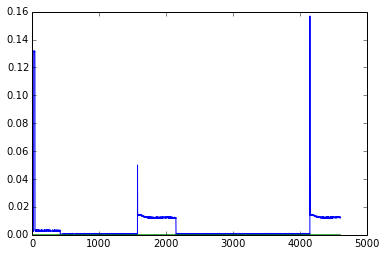

In [118]:
plt.plot(range(len(x_train__[0])), x_train__[0])
plt.subplot()
plt.plot(range(len(y_train__[0])), y_train__[0])

[[[2.0176694e+00]
  [2.3363372e-02]
  [1.6110863e-03]
  ...
  [1.0638726e-03]
  [1.8686628e-02]
  [1.4229643e+00]]]


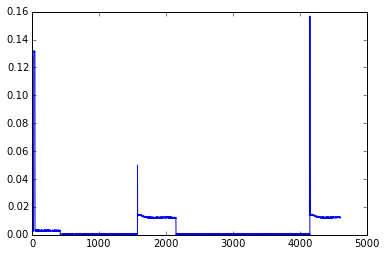

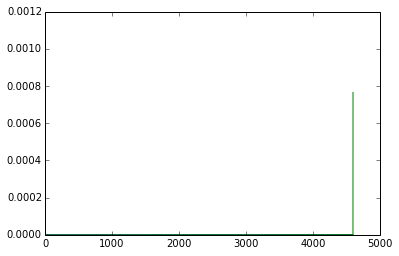

In [119]:
# example prediction on the noisy input signal
decoded = nilm_autoencoder.predict(
    np.reshape(x_train__[0], (1, nilm_window_size, 1))
)

# scale up to the max power registered for the device
print decoded * max_t[dev_id]
decoded.shape

dec_y = np.reshape(decoded, nilm_window_size)

plt.plot(x_train__[0])
plt.figure()
plt.plot(y_train__[0])
plt.plot(dec_y)

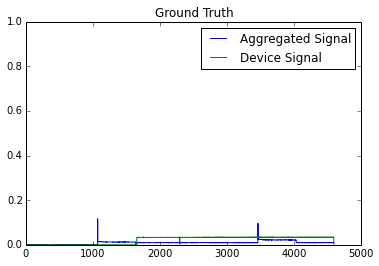

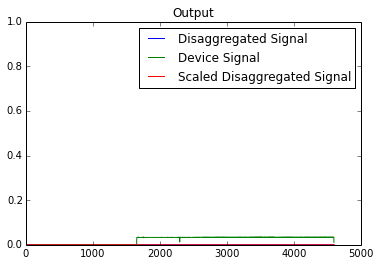

In [120]:
for i, y_ts in enumerate(y_train__):
    if np.count_nonzero(y_ts) > 2948:
        # example prediction on the noisy input signal
        decoded = nilm_autoencoder.predict(np.reshape(x_train__[i], (1, nilm_window_size, 1)))
        dec_y = np.reshape(decoded, nilm_window_size)
        # scale up to the max power registered for the device
        decoded_s = decoded * max_t[dev_id]
        dec_y_s = np.reshape(decoded, nilm_window_size)

        plt.title('Ground Truth')
        agg_ts, = plt.plot(x_train__[i])
        a_dev_ts, = plt.plot(y_train__[i])
        plt.legend([agg_ts, a_dev_ts], ["Aggregated Signal", "Device Signal"])
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,0.0,1.0))
        
        plt.figure()
        plt.title('Output')
        dis_ts, = plt.plot(dec_y)
        dev_ts, = plt.plot(y_train__[i])
        dis_s_ts, = plt.plot(dec_y_s)
        plt.legend([dis_ts, dev_ts, dis_s_ts], ["Disaggregated Signal", "Device Signal", "Scaled Disaggregated Signal"])
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,0.0,1.0))
        break

In [107]:
print len( y_train__)

cc = [ (i, np.count_nonzero(y_train__[i])) for i, k in enumerate(y_train__) if np.count_nonzero(y_train__[i]) > 1000 ]

226239


In [111]:
max([c[1] for c in cc])

2949

In [115]:
filter(lambda c: c[1] > 2948, cc)

[(47361, 2949),
 (47362, 2949),
 (47363, 2949),
 (47364, 2949),
 (47365, 2949),
 (47366, 2949),
 (47367, 2949),
 (47368, 2949),
 (47369, 2949),
 (47370, 2949),
 (47371, 2949),
 (47372, 2949),
 (47373, 2949),
 (47374, 2949),
 (47375, 2949),
 (47376, 2949),
 (47377, 2949),
 (47378, 2949),
 (47379, 2949),
 (47380, 2949),
 (47381, 2949),
 (47382, 2949),
 (47383, 2949),
 (47384, 2949),
 (47385, 2949),
 (47386, 2949),
 (47387, 2949),
 (47388, 2949),
 (47389, 2949),
 (47390, 2949),
 (47391, 2949),
 (47392, 2949),
 (47393, 2949),
 (47394, 2949),
 (47395, 2949),
 (47396, 2949),
 (47397, 2949),
 (47398, 2949),
 (47399, 2949),
 (47400, 2949),
 (47401, 2949),
 (47402, 2949),
 (47403, 2949),
 (47404, 2949),
 (47405, 2949),
 (47406, 2949),
 (47407, 2949),
 (47408, 2949),
 (47409, 2949),
 (47410, 2949),
 (47411, 2949),
 (47412, 2949),
 (47413, 2949),
 (47414, 2949),
 (47415, 2949),
 (47416, 2949),
 (47417, 2949),
 (47418, 2949),
 (47419, 2949),
 (47420, 2949),
 (47421, 2949),
 (47422, 2949),
 (47423,